## Figure 3 - Modeling Results of the ALOS-1 observation

The following steps are required before running the notebook.

+ 1. [Prepare GBIS input file](GBIS_1_prepare_input.ipynb)
+ 2. Run GBIS in Matlab
+ 3. [Load GBIS inversion result into HDF5 file](GBIS_2_load_inversion_result.ipynb)

In [219]:
%matplotlib inline
import os
import h5py
import glob
import numpy as np
from matplotlib import pyplot as plt, ticker
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy.defaults.plot import *
from mintpy import view

work_dir = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model')
os.chdir(work_dir)
print('Go to directory', work_dir)

## Data Info

dem_file = os.path.expanduser('~/insarlab/Kirishima/KirishimaAlos2AT131/mintpy/inputs/gsi10m.dem.wgs84')

# Shinmoe-dake crater ring lon/lat
crater_lonlat_file = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/data/Shinmoe_crater_lonlat.xy')
fc = np.loadtxt(crater_lonlat_file, dtype=bytes, comments='>').astype(float)
crater_lons = fc[:,0]
crater_lats = fc[:,1]

# Shinmoe-dake vent of the 2008 phreatic eruption
vent_lalo = [31.9113, 130.8795]  #S-17 in Fig. 2 in Geshi et al., 2010

# inversion result dir
inv_res_dir = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/GBIS')

# inversion dataset
ds_list = [
    'Iwo2017pre/invert_1_2_C',
    'Iwo2017post/invert_1_2_C_C2',
    'Shinmoe2008post/invert_1_2_C',
    'Shinmoe2017pre/invert_1_2_T',
]

model_lalos = [
    [31.9470, 130.8532],
    [31.9463, 130.8530],
    [31.9125, 130.8844],
    [31.9111, 130.8826],
]

Go to directory /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model


In [349]:
## Utilities function

def plot_data_model_map(fnames, sub, defo_name, profile=None, model_lalo=None, figsize=[3.6, 3.0]):
    # input dataset
    cmd0s = [
        'view.py {} data'.format(fnames[0]),
        'view.py {} data'.format(fnames[1]),
        'view.py {} model'.format(fnames[0]),
        'view.py {} model'.format(fnames[1]),
    ]

    # options for view.py
    opt = ' --noverbose --notitle --nocbar --notick --ref-size 2 --fontsize 12 ' #--notick
    opt += ' -u cm --wrap --wrap-range -5 5 -c jet --noreference '
    opt += ' --scalebar 0.3 0.25 0.075 --scalebar-pad 0.1 '

    # plot
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    axs = axs.flatten()
    for i in range(len(axs)):
        ax = axs[i]
        
        # plot displacement
        cmd = cmd0s[i]+opt+sub
        if i != 0:
            cmd += ' --noscalebar'
        d_v, atr, inps = view.prep_slice(cmd)
        im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
        
        # plot profile
        if profile is not None:
            [[lat0, lon0], [lat1, lon1]] = profile
            ax.plot([lon0,lon1], [lat0,lat1], 'k--', lw=1)
        
        # annotation for Shinmoe-dake
        if 'Shinmoe' in defo_name:
            # plot the ring of the crater
            ax.plot(crater_lons, crater_lats, 'k-', lw=0.5)
            
            # plot the vent location
            if 'Shinmoe2008' in defo_name and i in [2,3]:
                ax.plot(vent_lalo[1], vent_lalo[0], '^', ms=6, lw=1.5, mec=pp.mplColors[1], fillstyle='none')
            
            # plot model centroid location
            if model_lalo is not None and i in [2,3]:
                if 'Shinmoe2008' in defo_name:
                    c = pp.mplColors[1]
                else:
                    c = pp.mplColors[0]
                ax.plot(model_lalo[1], model_lalo[0], '*', ms=9, lw=1.5, mec=c, fillstyle='none')
            
    fig.subplots_adjust(wspace=0.05, hspace=0.03, left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    # output
    out_file = os.path.abspath('{}_map.png'.format(defo_name))
    plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('save figure to', out_file)
    return fig, axs, im


def get_data_model_transection(inv_file, profile):
    # data
    data, atr = readfile.read(inv_file, datasetName='data')
    txn_data  = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    # model
    data, atr = readfile.read(inv_file, datasetName='model')
    txn_model = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    # output
    txn = dict()
    txn['distance'] = txn_data['distance'] / 1000.   #km
    txn['data'] = txn_data['value'] * 100.           #cm
    txn['model'] = txn_model['value'] * 100.         #cm
    return txn


def plot_data_model_profile(fnames, profile, dem_file, defo_name, offset=15, ylim=[-30,15], figsize=[1.7, 1.7]):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    # plot displacement - ax
    colors = [pp.mplColors[1], pp.mplColors[0]]
    for i in range(len(fnames)):
        off = (1-i)*offset + 10
        txn = get_data_model_transection(fnames[i], profile)
        ax.scatter(txn['distance'], txn['data']+off, facecolors='none', edgecolors=colors[i], s=3**2, alpha=0.5, label='data')
        ax.plot(txn['distance'], txn['model']+off, c=colors[i], lw=2, label='model')

    # plot topography - ax2
    data, atr = readfile.read(dem_file)
    txn2 = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    ax2 = ax.twinx()
    ax2.fill_between(txn2['distance']/1000., txn2['value']/1000., facecolor='gray', alpha=0.3, zorder=0)

    # axis format - ax
    ax.set_xlim(0, np.max(txn['distance']))
    ax.set_ylim(ylim)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    
    # axis format - ax2
    ax2.set_ylim(1.0, 4.5)
    ax2.set_yticks(np.arange(0.5, 1.6, 0.5))
    ax2.tick_params(which='both', direction='out', colors='k', labelsize=font_size, bottom=True, top=False, left=False, right=True)

    # axis ticklabel
    ax.set_xlabel('Distance [km]', fontsize=font_size)
    if defo_name in ['Iwo2017pre', 'Shinmoe2008post']:
        ax2.get_yaxis().set_ticklabels([])
        ax.set_ylabel('LOS displacement [cm]', fontsize=font_size, y=0.36)
    else:
        ax2.set_ylabel('Elevation [km]', fontsize=font_size, y=0.13)
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    # output
    out_file = os.path.abspath('{}_profile.png'.format(defo_name))
    plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('save figure to', out_file)
    return fig, ax

print('Utilities functions initiated.')

Utilities functions initiated.


save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Iwo2017pre_map.png
save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Iwo2017pre_profile.png


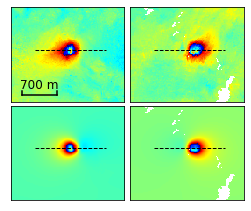

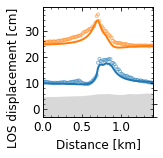

save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Iwo2017post_map.png
save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Iwo2017post_profile.png


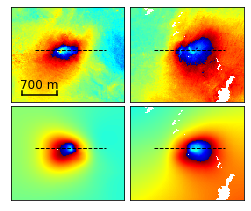

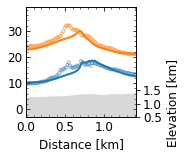

save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Shinmoe2008post_map.png
save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Shinmoe2008post_profile.png


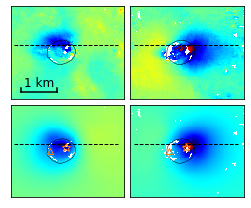

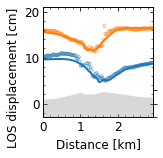

save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Shinmoe2017pre_map.png
save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/Shinmoe2017pre_profile.png


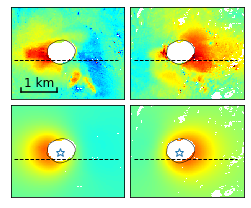

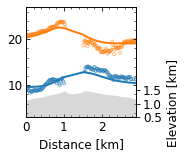

Done.


In [350]:
## Plot Configurations
subsets = [
    ' --sub-lat 31.936  31.956 --sub-lon 130.840 130.864 ',  # Iwo 2017 pre
    ' --sub-lat 31.936  31.956 --sub-lon 130.840 130.864 ',  # Iwo 2017 post
    ' --sub-lat 31.8975 31.925 --sub-lon 130.868 130.902 ',  # Shinmoe 2008 post
    ' --sub-lat 31.8975 31.925 --sub-lon 130.868 130.902 ',  # Shinmoe 2017 pre
]

profiles = [
    [[31.947 , 130.845 ], [31.947 , 130.860]],   #Iwo-yama at 0.8 km
    [[31.947 , 130.845 ], [31.947 , 130.860]],
    [[31.9136, 130.869 ], [31.9136, 130.900]],   #[[31.915, 130.865], [31.915, 130.900]],
    [[31.909 , 130.869 ], [31.909 , 130.900]],
]

ylims = [
    [-3, 39],
    [-3, 39],
    [-3, 21],
    [ 3, 27],
]

offsets = [15, 12, 6, 10]

## Plot
for i in range(len(ds_list)):
    defo_name, model_name = ds_list[i].split('/')
    fnames = sorted(glob.glob(os.path.join(inv_res_dir, defo_name, model_name, 'Kirishima*.h5')))

    # plot map
    fig, axs, im = plot_data_model_map(fnames, subsets[i], defo_name=defo_name, profile=profiles[i], model_lalo=model_lalos[i])

    # plot profile
    fig, ax = plot_data_model_profile(fnames, profiles[i], dem_file, defo_name=defo_name, offset=offsets[i], ylim=ylims[i])

    plt.show()
print('Done.')

save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/map_cbar.png


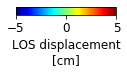

In [334]:
## Plot colorbar
fig, cax = plt.subplots(nrows=1, ncols=1, figsize=[1.8, 0.15])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS displacement\n[cm]', fontsize=font_size)
#cbar.ax.xaxis.set_label_position("top")

# output
out_file = os.path.abspath('map_cbar.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_vs_model/profile_legend.png


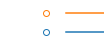

In [327]:
# legend
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[1.5, 0.5])
ax.plot(4,8,'o', c=pp.mplColors[1], fillstyle='none')
ax.plot(4,2,'o', c=pp.mplColors[0], fillstyle='none')
ax.plot([6,10],[8,8],'-', c=pp.mplColors[1])
ax.plot([6,10],[2,2],'-', c=pp.mplColors[0])

ax.axis('off')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

out_file = os.path.abspath('profile_legend.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

## Plot ALL Models

In [2]:
# inversion model

model_names = ['C', 'Y', 'T'] #, 'N', 'M']
inv_dir_base = os.path.expanduser('~/insarlab/Kirishima/Model/Shinmoe2008post')
inv_dirs = [os.path.join(inv_dir_base, 'invert_1_2_{}'.format(i)) for i in model_names]

# run load_gbis.py
update_mode = True
#if not update_mode or 

inv_files_asc  = [os.path.join(i, 'ShinmoeAlosAT424_20080929_20100520.h5') for i in inv_dirs]
inv_files_desc = [os.path.join(i, 'ShinmoeAlosDT73_20081012_20100302.h5') for i in inv_dirs]

cmd_list_asc = ['view.py {} model'.format(i) for i in inv_files_asc]
cmd_list_asc = ['view.py {} data'.format(inv_files_asc[0])] + cmd_list_asc
cmd_list_desc = ['view.py {} model'.format(i) for i in inv_files_desc]
cmd_list_desc = ['view.py {} data'.format(inv_files_desc[0])] + cmd_list_desc
cmds = np.array([cmd_list_asc, cmd_list_desc]).T.flatten()

In [3]:
# load GBIS inversion result from .mat into HDF5 format.
for inv_dir in inv_dirs:
    mat_file = '{}.mat'.format(os.path.basename(inv_dir))
    mat_file = os.path.join(inv_dir, mat_file)
    cmd = 'load_gbis.py {} --nodisplay'.format(mat_file)
    print(cmd)
    #os.system(cmd)

load_gbis.py /Users/yunjunz/insarlab/Kirishima/Model/Shinmoe_2008/invert_1_2_C/invert_1_2_C.mat --nodisplay
load_gbis.py /Users/yunjunz/insarlab/Kirishima/Model/Shinmoe_2008/invert_1_2_Y/invert_1_2_Y.mat --nodisplay
load_gbis.py /Users/yunjunz/insarlab/Kirishima/Model/Shinmoe_2008/invert_1_2_T/invert_1_2_T.mat --nodisplay


model centroid of CDMN: E130.8843, N31.9133
model centroid of YANG: E130.8850, N31.9146
model centroid of MCTG: E130.8848, N31.9137
save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/Shinmoe_model/model_map_all.png


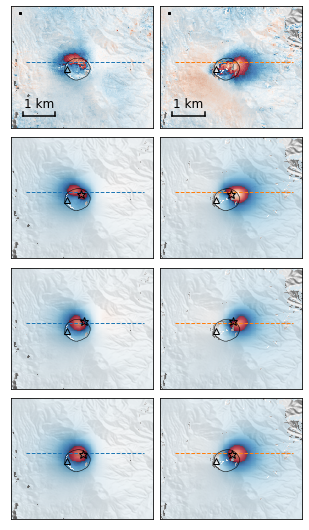

In [5]:
# prepare view.py command line
opt = ' --noverbose --notitle --nocbar --notick --ref-size 2 --fontsize 12 ' #--notick
opt += ' -u cm --wrap --wrap-range -3 3 -c RdBu_r '
opt += ' --sub-lat 31.892 31.932 --sub-lon 130.861 130.908 '
opt += ' --scalebar 0.3 0.2 0.1 --scalebar-pad 0.1 '
opt += ' --dem {} --dem-nocontour --shade-az 45 '.format(dem_file)

# plot
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=[4.5, 8])
locs = pp.auto_shared_lalo_location(axs, loc=(1,0,0,1), flatten=True)
axs = axs.flatten()
for i in range(len(axs)):
    ax = axs[i]
    
    # plot data and DEM
    cmd = cmds[i]+opt #+' --lalo-label --lalo-step 0.02 --lalo-loc {} {} {} {}'.format(locs[i][0], locs[i][1], locs[i][2], locs[i][3])
    if i >= 2:
        cmd += ' --noscalebar --noreference'
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    # plot profile location
    [[y0,x0], [y1,x1]] = profile_hz
    ax.plot([x0,x1], [y0,y1], '--', lw=1, c=pp.mplColors[i%2])
    
    # plot the ring of the crater
    ax.plot(crater_lons, crater_lats, 'k-', lw=0.5)

    # plot the vent location
    ax.plot(vent_lalo[1], vent_lalo[0], 'k^', ms=6, fillstyle='none')

    # plot optimal model location
    if i >=2:
        model_name = atr['DEFORMATION_MODEL']
        model_lat = float(atr['{}_LAT'.format(model_name)])
        model_lon = float(atr['{}_LON'.format(model_name)])
        if i%2 == 0: #print it once
            print('model centroid of {}: E{:.4f}, N{:.4f}'.format(model_name, model_lon, model_lat))
        ax.plot(model_lon, model_lat, 'k*', ms=9, fillstyle='none')
fig.subplots_adjust(wspace=0.05, hspace=0.03, left=0.05, right=0.95, top=0.95, bottom=0.05)

# output
out_file = os.path.abspath('model_map_all.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()

save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/Shinmoe_model/model_map_cbar.png


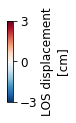

In [50]:
# colorbar
fig, cax = plt.subplots(nrows=1, ncols=1, figsize=[0.1, 1.5])
cbar = plt.colorbar(im, cax=cax, orientation='vertical', ticks=[-3, 0, 3])
cbar.ax.tick_params(labelsize=font_size)
#cbar.ax.xaxis.tick_top()
#cbar.ax.xaxis.set_label_position('top')
cbar.set_label('LOS displacement\n[cm]', fontsize=font_size)

# output
out_file = os.path.abspath('model_map_cbar.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()

save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/Shinmoe_model/model_profile_all.png


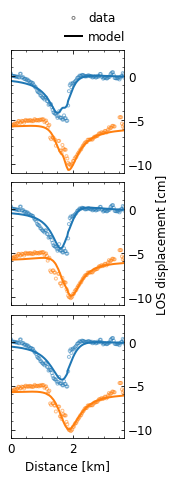

In [37]:
## Figure 3 - Inversion result

def get_data_model_transection(inv_file, profile):
    # data
    data, atr = readfile.read(inv_file, datasetName='data')
    txn_data  = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    # model
    data, atr = readfile.read(inv_file, datasetName='model')
    txn_model = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    # output
    txn = dict()
    txn['distance'] = txn_data['distance'] / 1000.   #km
    txn['data'] = txn_data['value'] * 100.           #cm
    txn['model'] = txn_model['value'] * 100.         #cm
    return txn

# plot
off = -5.5

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[1.75, 6], sharex=True, sharey=True)
for i in range(len(axs)):
    ax = axs[i]

    # read transection data
    inv_file = inv_files_asc[i]
    txn = get_data_model_transection(inv_file, profile_hz)

    # plot
    c = pp.mplColors[0]
    ax.scatter(txn['distance'], txn['data'], facecolors='none', edgecolors=c, s=3**2, alpha=0.5, label='data')
    ax.plot(txn['distance'], txn['model'], c=c, lw=2, label='model')

    # read transection data
    inv_file = inv_files_desc[i]
    txn = get_data_model_transection(inv_file, profile_hz)

    # plot
    c = pp.mplColors[1]
    ax.scatter(txn['distance'], txn['data']+off, facecolors='none', edgecolors=c, s=3**2, alpha=0.5, label='data')
    ax.plot(txn['distance'], txn['model']+off, c=c, lw=2, label='model')

    # axis format
    ax.set_xlim(0, np.max(txn['distance']))
    ax.set_ylim(-11, 3)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(wspace=0.05, hspace=0.08, left=0.05, right=0.95, top=0.95, bottom=0.05)
axs[-1].set_xlabel('Distance [km]', fontsize=font_size)
pp.set_shared_ylabel(axs, 'LOS displacement [cm]', font_size=font_size, position='right', labelpad=1.2)

# legend
ax = axs[0]
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(reversed(handles[0::2]), reversed(labels[0::2]),
                loc='upper left', bbox_to_anchor=(0.35, 1.4),
                fontsize=font_size, frameon=False, handletextpad=0.2,
                ncol=1, numpoints=3, columnspacing=0.1)
leg.legendHandles[0].set_edgecolors('black')
leg.legendHandles[1].set_color('black')

# output
out_file = os.path.abspath('model_profile_all.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()

## Plot Best-fit Model

In [3]:
# GBIS inversion result --> HDF5 file
# inversion model
inv_dir = os.path.expanduser('~/insarlab/Kirishima/Model/Shinmoe2008post/invert_1_2_C')
model_name = inv_dir[-1]

inv_files = [os.path.join(inv_dir, 'ShinmoeAlosAT424_20080929_20100520.h5'),
             os.path.join(inv_dir, 'ShinmoeAlosDT73_20081012_20100302.h5')]
update_mode = True
if not update_mode or not all(os.path.isfile(i) for i in inv_files):
    mat_file = os.path.join(inv_dir, '{}.mat'.format(os.path.basename(inv_dir)))
    cmd = 'load_gbis.py {} --nodisplay '.format(mat_file)
    print(cmd)
    !{cmd}
print('all GBIS inversion result HDF5 files exist.')

all GBIS inversion result HDF5 files exist.


## Volume change and evacuation rate

In [21]:
## volume change and its rate
atr = readfile.read_attribute(inv_files[0])
aX = float(atr['CDMN_aX'])
aY = float(atr['CDMN_aY'])
aZ = float(atr['CDMN_aZ'])
op = float(atr['CDMN_Opening'])

delta_vol = 4 * (aX*aY + aY*aZ + aX*aZ) * op / 1e6
print('cavity volume change: {:.2f} * 10^6 m^3'.format(delta_vol))

dt1 = np.diff(ptime.yyyymmdd2years(readfile.read_attribute(inv_files[0])['DATE12'].split('_')))[0]
dt2 = np.diff(ptime.yyyymmdd2years(readfile.read_attribute(inv_files[1])['DATE12'].split('_')))[0]
tdiff = (dt1 + dt2) / 2
print('average observation length in years: {:.2f}'.format(tdiff))
delta_vol_rate = delta_vol / tdiff
delta_vol_rate_err = 0.02 / tdiff
print('cavity volume change rate: {:.2f} +/- {:.2f} * 10^6 m^3/year'.format(delta_vol_rate, delta_vol_rate_err))

cavity volume change: -0.11 * 10^6 m^3
average observation length in years: 1.51
cavity volume change rate: -0.07 +/- 0.01 * 10^6 m^3/year


save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/notebooks/Shinmoe_model/model_map_C.png


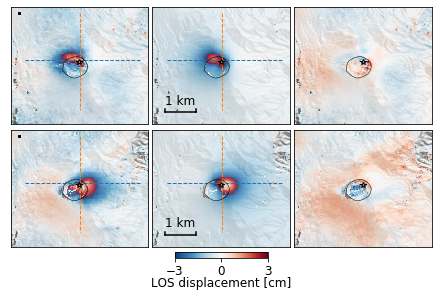

In [25]:
## Figure 3 - Inversion result
ds_names = ['data', 'model', 'residual']

# read data - map
cmd_list = []
for inv_file in inv_files:
    for ds_name in ds_names:
        cmd = 'view.py {} {}'.format(inv_file, ds_name)
        cmd_list.append(cmd)

# plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[6.5, 4], sharex=True, sharey=True)
axs = axs.flatten()
dmin, dmax = -5, 5

for i in range(len(cmd_list)):
    ax = axs[i]
    # prepare view.py command line
    cmd = cmd_list[i]+' -u cm -v {} {} '.format(dmin, dmax)
    cmd += ' --noverbose --notitle --nocbar --notick --ref-size 2 --fontsize 12 '
    cmd += ' --wrap --wrap-range -3 3 -c RdBu_r '
    cmd += ' --sub-lat 31.892 31.932 --sub-lon 130.861 130.908 '
    cmd += ' --scalebar 0.3 0.2 0.1 --scalebar-pad 0.1 '
    cmd += ' --dem {} --dem-nocontour --shade-az 45 '.format(dem_file)
    if i in [0,2,3,5]:
        cmd += ' --noscalebar '
    if i in [1,2,4,5]:
        cmd += ' --noreference '
    # call view.py
    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)

    # plot profile location on data/model subplots only
    if i in [0,1,3,4]:
        [[y0,x0], [y1,x1]] = profile_hz
        ax.plot([x0,x1], [y0,y1], '--', lw=1, c=pp.mplColors[0])
        [[y0,x0], [y1,x1]] = profile_up
        ax.plot([x0,x1], [y0,y1], '--', lw=1, c=pp.mplColors[1])

    # plot the ring of the crater
    ax.plot(crater_lons, crater_lats, 'k-', lw=0.5)

    # plot optimal model location
    ax.plot(float(atr['CDMN_longitude']), float(atr['CDMN_latitude']), 'k*', fillstyle='none')
fig.subplots_adjust(wspace=0.03, hspace=-0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)

# colorbar
cax = fig.add_axes([0.4, 0.045, 0.2, 0.02])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-3, 0, 3])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS displacement [cm]', fontsize=font_size, labelpad=-1)

# output
out_file = os.path.abspath('model_map_{}.png'.format(model_name))
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()

save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/notebooks/Shinmoe_model/model_profile_C.png


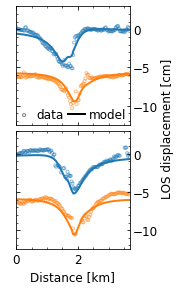

In [16]:
## Figure 3 - Inversion result
ds_names = ['data', 'model']

# read transection data
txn_hz_list = []
txn_up_list = []
for inv_file in inv_files:
    for ds_name in ds_names:
        data, atr = readfile.read(inv_file, datasetName=ds_name)
        txn_hz = ut.transect_lalo(data, atr, start_lalo=profile_hz[0], end_lalo=profile_hz[1])
        txn_up = ut.transect_lalo(data, atr, start_lalo=profile_up[0], end_lalo=profile_up[1])
        txn_hz_list.append(txn_hz)
        txn_up_list.append(txn_up)

# plot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[1.75, 3.75], sharex=True, sharey=True)
for i in range(len(axs)):
    ax = axs[i]
    # hz / up profile
    off = 0
    for txn_list, c in zip([txn_hz_list, txn_up_list], pp.mplColors[0:2]):
        txn = txn_list[i*2]
        ax.scatter(txn['distance']/1000.0, txn['value']*100.0 + off,
                   facecolors='none', edgecolors=c, s=3**2, alpha=0.5, label='data')
        txn = txn_list[i*2+1]
        ax.plot(txn['distance']/1000.0, txn['value']*100.0 + off, c=c, lw=2, label='model')
        off -= 5.5

    # axis format
    ax.set_xlim(0, np.max(txn_hz_list[0]['distance']/1000.0))
    ax.set_ylim(-12.5, 3)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)
axs[1].set_xlabel('Distance [km]', fontsize=font_size)
pp.set_shared_ylabel(axs, 'LOS displacement [cm]', font_size=font_size, position='right', labelpad=1.2)

# legend
ax = axs[0]
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(reversed(handles[0::2]), reversed(labels[0::2]), loc='lower right',
                fontsize=font_size, frameon=False, borderaxespad=-0.1, handletextpad=0,
                ncol=2, numpoints=3, columnspacing=0.1)
leg.legendHandles[0].set_edgecolors('black')
leg.legendHandles[1].set_color('black')

# output
out_file = os.path.abspath('model_profile_{}.png'.format(model_name))
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()